In [9]:
import os
os.chdir('D://scratch_backup//perl//alpine_reprocess//mnc-pt-pyrid//calcs//surfs//4n//No_bias')
import numpy as np
import funcs as func
import matplotlib.pyplot as plt
bandfile='bandProjections'
gvecfile='Gvectors'
eigfile='eigenvals'
proj, nStates, nBands, nProj, nSpecies, nOrbsPerAtom = func.parse_bandfile(bandfile)
wk, iGarr, k_points, nStates = func.parse_gvecfile(gvecfile)
E = func.parse_eigfile(eigfile, nStates)
c_orbs = nOrbsPerAtom[0]*44
n_orbs = nOrbsPerAtom[1]*4
pt_orbs = nOrbsPerAtom[2]*1
def T_ijk(iorb, jband, kstate):
	return proj[kstate][jband][iorb]
def P_uvjk(uorb,vorb,jband, kstate):
	return np.conjugate(T_ijk(uorb, jband, kstate))*T_ijk(vorb, jband, kstate)
def e_jk(jband,kstate):
	return E[kstate][jband]
def H_uvk(uorb,vorb,kstate):
	sum_hold = 0
	for j in range(nBands):
		sum_hold += e_jk(j, kstate)*P_uvjk(uorb, vorb, j, kstate)
	return sum_hold
def pCOHP_uvk(uorb,vorb,kstate,Emin,Emax,dE):
	Huvk = H_uvk(uorb,vorb,kstate)
	Egrid = np.arange(Emin, Emax + dE, dE)
	output = np.zeros(np.shape(Egrid))
	for j in range(nBands):
		ejk = e_jk(j, kstate)
		if ((ejk < Emax) and (ejk > Emin)):
			e_idx = int(np.floor((ejk - Emin)/dE))
			e_weight = ejk - Egrid[e_idx]
			e_spill = Egrid[int(e_idx + 1)] - ejk
			x = P_uvjk(uorb, vorb, j, kstate) * Huvk
			output[e_idx] += np.real(x) * e_weight
			output[e_idx+1] += np.real(x) * e_spill
	return output, Egrid
def pCOHP_uv(uorb,vorb,Emin,Emax,dE):
	Egrid = np.arange(Emin, Emax + dE, dE)
	output = np.zeros(np.shape(Egrid))
	for k in range(nStates):
		output += pCOHP_uvk(uorb,vorb,k,Emin,Emax,dE)[0] * wk[k]
	return output, Egrid

def pCOHP_uvk_u(uorb,vorb,kstate,Emin,Emax,dE):
	Huvk = H_uvk(uorb,vorb,kstate)
	Egrid = np.arange(Emin, Emax + dE, dE)
	output = np.zeros(np.shape(Egrid))
	for j in range(nBands):
		ejk = e_jk(j, kstate)
		if ((ejk < Emax) and (ejk > Emin)):
			e_idx = int(np.floor((ejk - Emin)/dE))
			e_weight = ejk - Egrid[e_idx]
			e_spill = Egrid[int(e_idx + 1)] - ejk
			x = P_uvjk(uorb, uorb, j, kstate) * Huvk
			output[e_idx] += np.real(x) * e_weight
			output[e_idx+1] += np.real(x) * e_spill
	return output, Egrid

def pCOHP_uv_u(uorb,vorb,Emin,Emax,dE):
	Egrid = np.arange(Emin, Emax + dE, dE)
	output = np.zeros(np.shape(Egrid))
	for k in range(nStates):
		output += pCOHP_uvk_u(uorb,vorb,k,Emin,Emax,dE)[0] * wk[k]
	return output, Egrid
def Hk_atomic_matrix(orb_idcs, k, array=False):
	dim = len(orb_idcs)
	out = []
	for i in range(dim):
		out.append([])
		for j in range(dim):
			out[-1].append(0)
	for i in range(dim):
		for j in range(dim):
			out[i][j] = H_uvk(orb_idcs[i],orb_idcs[j],k)
	if array:
		return np.array(out)
	else:
		return out

def H_atomic_matrices(orb_idcs, k_points, array=False, select=None):
	if select is None:
		select = range(len(k_points))
	out = []
	for k in select:
		out.append(Hk_atomic_matrix(orb_idcs, k, array=array))
	return out

def H_atomic_matrix(orb_idcs, select=None):
	matrices = H_atomic_matrices(orb_idcs, k_points, array=True, select=select)
	out = np.zeros(np.shape(matrices[0]), dtype=complex)
	for i in range(len(k_points)):
		out += matrices[i]*wk[i]
	return out
orbs = range(nProj)
H_gamma_atomic = Hk_atomic_matrix(orbs, 0, array=True)
Hks_atomic = H_atomic_matrices(orbs, k_points, array=True)
H_atomic = H_atomic_matrix(orbs)

In [14]:
header, data = func.parse_dos('dosUp')

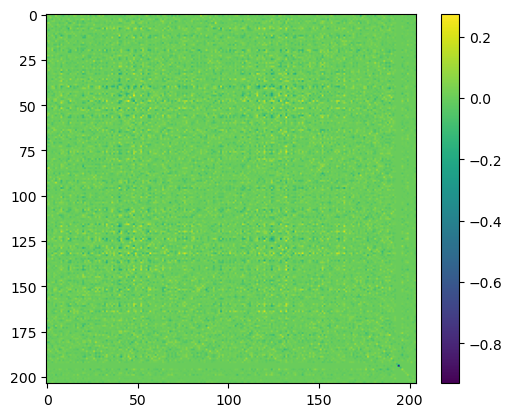

In [11]:
plt.imshow(np.real(H_atomic))
plt.colorbar()

In [93]:
import sys
sys.path.append('C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//chgcar_stuff')
import test_funcs

In [95]:
test_funcs.hello(1)

1


In [12]:
c_orb_idcs = range(c_orbs)
n_orb_idcs = range(c_orbs, c_orbs + n_orbs)
pt_orb_idcs = range(c_orbs + n_orbs, c_orbs + n_orbs + pt_orbs)

In [85]:
import matplotlib.pyplot as plt
pts = 4000

minE = np.min(E)
maxE = np.max(E)
print(maxE-minE)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
pCOHP_sum = np.zeros(np.shape(Egrid))
c_orb_idcs = range(c_orbs)
n_orb_idcs = range(c_orbs, c_orbs + n_orbs)
pt_orb_idcs = range(c_orbs + n_orbs, c_orbs + n_orbs + pt_orbs)
for u in n_orb_idcs:
	for v in pt_orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]

pCOHP_u_sum = np.zeros(np.shape(Egrid))
for u in n_orb_idcs:
	for v in pt_orb_idcs:
		pCOHP_u_sum += pCOHP_uv_u(u, v, minE, maxE, dE)[0]

pCOHP_v_sum = np.zeros(np.shape(Egrid))
for u in n_orb_idcs:
	for v in pt_orb_idcs:
		pCOHP_v_sum += pCOHP_uv_u(v, u, minE, maxE, dE)[0]

2.138142723333553


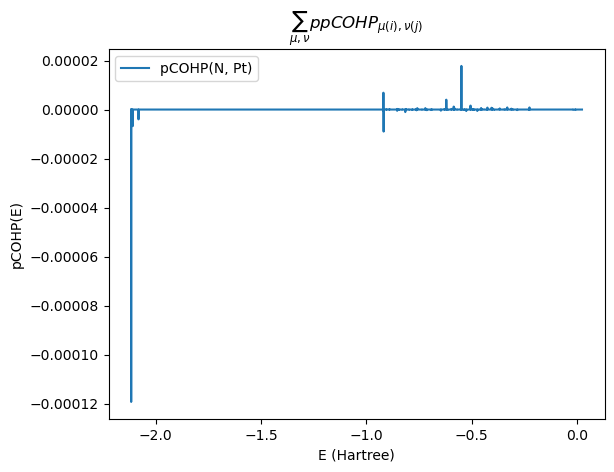

In [86]:
contribs = False
putmu = True
plt.plot(Egrid, pCOHP_sum, label='pCOHP(N, Pt)')
minval = min(pCOHP_sum)
maxval = max(pCOHP_sum)
if contribs:
	plt.plot(Egrid, pCOHP_u_sum, label='pCOHP_u(N, Pt)')
	minval = min(min(pCOHP_u_sum), minval)
	maxval = max(max(pCOHP_u_sum), maxval)
	plt.plot(Egrid, pCOHP_v_sum, label='pCOHP_v(N, Pt)')
	minval = min(min(pCOHP_v_sum), minval)
	maxval = max(max(pCOHP_v_sum), maxval)
if putmu:
	plt.axvline(x=mu)
plt.title(r'$\sum_{\mu,\nu}ppCOHP_{\mu(i),\nu(j)}$')
plt.xlabel('E (Hartree)')
plt.ylabel('pCOHP(E)')
plt.legend()
#plt.xlim(-2.1175, -2.115)
#plt.ylim(-5E-6, 5E-6)
savename = 'ppCOHP_Pt_N_'
if contribs:
	savename += 'wctb_'
savename += 'all_' + str(pts) + 'pts.png'
#plt.savefig(savename, bbox_inches='tight', facecolor='white')

In [92]:
np.abs(int(np.log10(0.00000000001)))

11

1.501684776708481


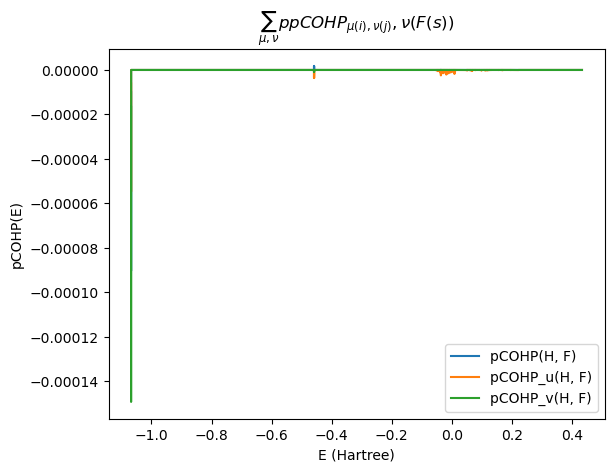

In [42]:
import matplotlib.pyplot as plt
pts = 16000

minE = np.min(E)
maxE = np.max(E)
print(maxE-minE)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
#orb_idcs = H(1s),F(2s),O(px),O(py),O(pz)
orb_idcs = [0,1,2,3,4]
H_orb_idcs = [0]
F_orb_idcs = [1]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in F_orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]

pCOHP_u_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in F_orb_idcs:
		pCOHP_u_sum += pCOHP_uv_u(u, v, minE, maxE, dE)[0]

pCOHP_v_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in F_orb_idcs:
		pCOHP_v_sum += pCOHP_uv_u(v, u, minE, maxE, dE)[0]

plt.plot(Egrid, pCOHP_sum, label='pCOHP(H, F)')
plt.plot(Egrid, pCOHP_u_sum, label='pCOHP_u(H, F)')
plt.plot(Egrid, pCOHP_v_sum, label='pCOHP_v(H, F)')

plt.title(r'$\sum_{\mu,\nu}ppCOHP_{\mu(i),\nu(j)},\nu(F(s))$')
plt.xlabel('E (Hartree)')
plt.ylabel('pCOHP(E)')
plt.legend()
# plt.xlim(-0.5, 0.2)
# plt.ylim(-0.00001, 0.00001)
plt.savefig('ppCOHP_H_F_F_2s_all_' + str(pts) + 'pts.png', bbox_inches='tight', facecolor='white')

1.501684776708481


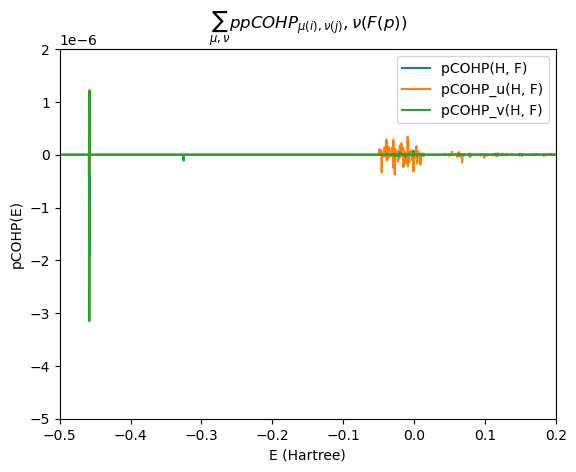

In [47]:
import matplotlib.pyplot as plt
pts = 16000

minE = np.min(E)
maxE = np.max(E)
print(maxE-minE)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
#orb_idcs = H(1s),F(2s),O(px),O(py),O(pz)
orb_idcs = [0,1,2,3,4]
H_orb_idcs = [0]
F_orb_idcs = [2,3,4]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in F_orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]

pCOHP_u_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in F_orb_idcs:
		pCOHP_u_sum += pCOHP_uv_u(u, v, minE, maxE, dE)[0]

pCOHP_v_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in F_orb_idcs:
		pCOHP_v_sum += pCOHP_uv_u(v, u, minE, maxE, dE)[0]

plt.plot(Egrid, pCOHP_sum, label='pCOHP(H, F)')
plt.plot(Egrid, pCOHP_u_sum, label='pCOHP_u(H, F)')
plt.plot(Egrid, pCOHP_v_sum, label='pCOHP_v(H, F)')

plt.title(r'$\sum_{\mu,\nu}ppCOHP_{\mu(i),\nu(j)},\nu(F(p))$')
plt.xlabel('E (Hartree)')
plt.ylabel('pCOHP(E)')
plt.legend()
plt.xlim(-0.5, 0.2)
plt.ylim(-0.000005, 0.000002)
plt.savefig('ppCOHP_H_F_F_2p_upper_' + str(pts) + 'pts.png', bbox_inches='tight', facecolor='white')

In [48]:
def Hk_atomic_matrix(orb_idcs, k, array=False):
	dim = len(orb_idcs)
	out = []
	for i in range(dim):
		out.append([])
		for j in range(dim):
			out[-1].append(0)
	for i in range(dim):
		for j in range(dim):
			out[i][j] = H_uvk(orb_idcs[i],orb_idcs[j],k)
	if array:
		return np.array(out)
	else:
		return out

def H_atomic_matrices(orb_idcs, k_points, array=False, select=None):
	if select is None:
		select = range(len(k_points))
	out = []
	for k in select:
		out.append(Hk_atomic_matrix(orb_idcs, k, array=array))
	return out

def H_atomic_matrix(orb_idcs, select=None):
	matrices = H_atomic_matrices(orb_idcs, k_points, array=True, select=select)
	out = np.zeros(np.shape(matrices[0]), dtype=complex)
	for i in range(len(k_points)):
		out += matrices[i]*wk[i]
	return out
orbs = [0,1,2,3,4]
H_gamma_atomic = Hk_atomic_matrix(orbs, 0, array=True)
Hks_atomic = H_atomic_matrices(orbs, k_points, array=True)
H_atomic = H_atomic_matrix(orbs)

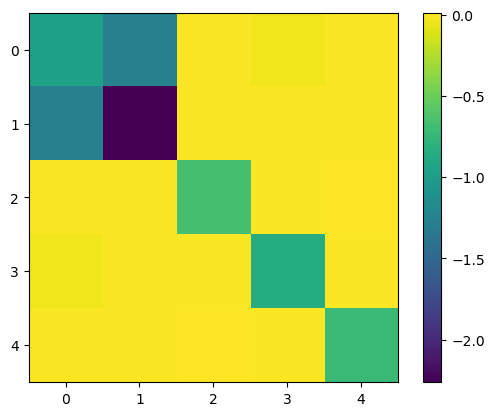

In [53]:
plt.imshow(np.real(H_atomic))
plt.colorbar()
plt.savefig('H_matrix_visualized.png')

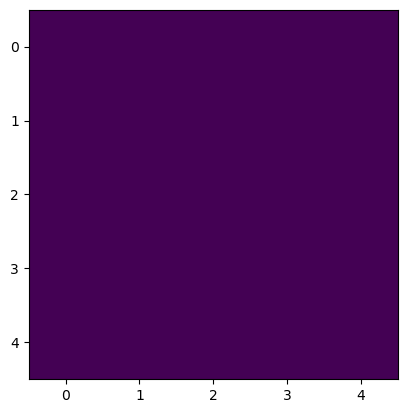

In [51]:
plt.imshow(np.imag(H_atomic))